In [111]:
# Import packages
import torch
from torch.optim import Adam
from Model.model import model
from Reinforcement_Learning.mol_env import vectorized_mol_env
from Model.graph_embedding import batch_from_states, visualize
import Model.masking as M
import numpy as np
from tqdm import trange
import datetime
import wandb
import copy
import rdkit.Chem as Chem

# Metrics
import rdkit.Chem.QED as QED # QED
import sys
import os
from rdkit.Chem import RDConfig
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer # SAS
from rdkit.Chem import Descriptors # MW
from rdkit.Chem import AllChem # Morgan fingerprints
from rdkit import DataStructs # Tanimoto diversity

from itertools import combinations
%load_ext autoreload
%autoreload 2

np.random.seed(42)
torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
model = model()
max_steps = 200
num_envs = 4
env = vectorized_mol_env(num_envs = num_envs, max_steps = max_steps) # Vectorized molecular environment
lr_0 = 0.02
lr_f = 0.0001

In [113]:
gamma = 0.99
eps = np.finfo(np.float32).eps.item() # Small constant to decrease numerical instability
num_episodes = 500

In [119]:
def evaluate(saved_states, saved_actions):
    """
    This methods evaluates the molecules generated during the episode and returns diversity, novelty, and validity.
    It also analyzes the molecule metrics of drug-likeness (QED), synthetic accessibility (SAS), and size.
    It only analyzes the finished molecules (i.e., after SURGE tells generation to terminate).
    """
    if 1 in saved_actions['t']:
        flattened_states = []
        flattened_t = []
        for i in range(saved_states.shape[1]):
            states_col = saved_states[:, i].flatten().tolist()
            t_col = saved_actions['t'][:, i].flatten().tolist()
            if i == 0:
                flattened_states = states_col
                flattened_t = t_col
            else:
                flattened_states += states_col
                flattened_t += t_col
        
        idx = [i for i, t in enumerate(flattened_t) if t == 1]
        finished_states = [flattened_states[idx[i]] for i in range(len(idx))]
    else:
        finished_states = [saved_states[i, saved_states.shape[1] - 1] for i in range(saved_states.shape[0])]
    
    
    # QED: From 0 to 1 where 1 is the most drug-like
    # SAS: From 1 to 10 where 1 is the easiest to synthesize
    metric_names = ['Average Size', 'Average MW', 'Average QED', 'Average SAS', 'Average Tanimoto Distance']
    num_mols = len(finished_states)
    metrics = dict()
    for name in metric_names:
        metrics[name] = 0
    
    fps = []
    for i in range(num_mols):
        finished_states[i].UpdatePropertyCache()
        if finished_states[i].GetNumAtoms() == 1:
            metrics['Average SAS'] = 0
            fps.append(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles('C'), 2, nBits=2048))
        else:
            metrics['Average SAS'] += sascorer.calculateScore(finished_states[i])
            fps.append(AllChem.GetMorganFingerprintAsBitVect(finished_states[i], 2, nBits=2048))
        metrics['Average Size'] += finished_states[i].GetNumAtoms()
        metrics['Average MW'] += Descriptors.MolWt(finished_states[i])
        metrics['Average QED'] += QED.weights_mean(finished_states[i])
    
    tanimoto_distances = []
    tanimoto_count = 0
    for i, j in combinations(range(len(fps)), 2):
        tanimoto = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        tanimoto_distances.append(1 - tanimoto)  # Convert Tanimoto similarity to distance
        tanimoto_count += 1
    
    for name in metric_names:
        metrics[name] /= num_mols
    metrics['Average Tanimoto Distance'] = sum(tanimoto_distances)/tanimoto_count
    return metrics

In [120]:
def calc_returns(saved_rewards, gamma):
    """
    Given multidimensional matrix of rewards, computes the returns.
    """
    prev_row = []
    for reward_idx in reversed(range(saved_rewards.shape[0])):
        cur_row = saved_rewards[reward_idx, :]
        if reward_idx == saved_rewards.shape[0] - 1:
            all_returns = cur_row
            prev_row = cur_row
        else:
            all_returns = torch.vstack((prev_row * gamma + cur_row, all_returns))
            prev_row = prev_row.to(torch.float32)
            prev_row *= gamma
            prev_row += cur_row
    return all_returns

Episode 1: 100%|██████████| 200/200 [00:02<00:00, 99.44steps/s] 


Average Size: 2.9651741293532337
Average MW: 150.82438805970096
Average QED: 0.47162203272986625
Average SAS: 0.0
Average Tanimoto Distance: 0.03812810945273632
Cumulative Reward: -25.090680093527993
Percent Invalid: 96.75


Episode 2: 100%|██████████| 200/200 [00:01<00:00, 104.20steps/s]


Average Size: 1.9402985074626866
Average MW: 23.366044776119452
Average QED: 0.32162934994721015
Average SAS: 0.0
Average Tanimoto Distance: 0.11283582089552238
Cumulative Reward: -27.11756706237793
Percent Invalid: 99.0


Episode 3: 100%|██████████| 200/200 [00:02<00:00, 88.94steps/s]


Average Size: 2.690909090909091
Average MW: 60.9436
Average QED: 0.35235286452410164
Average SAS: 0.35992294298666583
Average Tanimoto Distance: 0.8524414471957867
Cumulative Reward: -63.98723540786925
Percent Invalid: 81.125


Episode 4: 100%|██████████| 200/200 [00:02<00:00, 81.89steps/s]


Average Size: 5.461538461538462
Average MW: 149.01176923076926
Average QED: 0.31119951144619995
Average SAS: 1.202566661712273
Average Tanimoto Distance: 0.859825059334855
Cumulative Reward: -33.88074459132913
Percent Invalid: 87.625


Episode 5: 100%|██████████| 200/200 [00:03<00:00, 58.32steps/s]


Average Size: 17.63681592039801
Average MW: 531.2404129353234
Average QED: 0.1126733619645751
Average SAS: 0.0
Average Tanimoto Distance: 0.7553559956987167
Cumulative Reward: -23.137362383889315
Percent Invalid: 85.875


Episode 6: 100%|██████████| 200/200 [00:04<00:00, 40.34steps/s]


Average Size: 18.059701492537314
Average MW: 605.3128258706463
Average QED: 0.10712035544267207
Average SAS: 0.0
Average Tanimoto Distance: 0.770783959704427
Cumulative Reward: -23.275309350437283
Percent Invalid: 80.5


Episode 7: 100%|██████████| 200/200 [00:09<00:00, 21.52steps/s]


Average Size: 16.696517412935325
Average MW: 496.2265323383085
Average QED: 0.14760009815720554
Average SAS: 0.0
Average Tanimoto Distance: 0.8851066793628931
Cumulative Reward: -18.039680358720375
Percent Invalid: 51.24999999999999


Episode 8: 100%|██████████| 200/200 [00:13<00:00, 14.90steps/s]


Average Size: 18.487562189054728
Average MW: 576.2460099502497
Average QED: 0.13104931594689181
Average SAS: 0.0
Average Tanimoto Distance: 0.891245315932233
Cumulative Reward: -15.00684369070617
Percent Invalid: 33.0


Episode 9: 100%|██████████| 200/200 [00:02<00:00, 76.47steps/s]


Average Size: 15.955223880597014
Average MW: 500.9956716417912
Average QED: 0.1739003681795418
Average SAS: 0.0
Average Tanimoto Distance: 0.8452178235707991
Cumulative Reward: -20.410987036412045
Percent Invalid: 4.125


Episode 10: 100%|██████████| 200/200 [00:02<00:00, 79.73steps/s]


Average Size: 15.83084577114428
Average MW: 499.8782985074628
Average QED: 0.18646083142849612
Average SAS: 0.0
Average Tanimoto Distance: 0.8402727319154016
Cumulative Reward: -20.14505215411565
Percent Invalid: 7.875


Episode 11: 100%|██████████| 200/200 [00:02<00:00, 79.47steps/s]


Average Size: 16.18905472636816
Average MW: 509.5897014925375
Average QED: 0.15940218843277548
Average SAS: 0.0
Average Tanimoto Distance: 0.8303904269593372
Cumulative Reward: -21.762414151260536
Percent Invalid: 1.125


Episode 12: 100%|██████████| 200/200 [00:02<00:00, 82.59steps/s]


Average Size: 16.054726368159205
Average MW: 505.70344776119447
Average QED: 0.17352818352550983
Average SAS: 0.0
Average Tanimoto Distance: 0.8450920150174676
Cumulative Reward: -20.7296765745968
Percent Invalid: 1.625


Episode 13: 100%|██████████| 200/200 [00:02<00:00, 84.64steps/s]


Average Size: 15.935323383084578
Average MW: 502.7170597014927
Average QED: 0.18761081543404276
Average SAS: 0.0
Average Tanimoto Distance: 0.8461970813739023
Cumulative Reward: -22.012436781173392
Percent Invalid: 1.875


Episode 14: 100%|██████████| 200/200 [00:02<00:00, 84.99steps/s]


Average Size: 15.980099502487562
Average MW: 503.3304477611941
Average QED: 0.18353587433231977
Average SAS: 0.0
Average Tanimoto Distance: 0.8154186348292822
Cumulative Reward: -21.045322149869598
Percent Invalid: 0.625


Episode 15: 100%|██████████| 200/200 [00:02<00:00, 83.50steps/s]


Average Size: 16.069651741293534
Average MW: 506.34253731343284
Average QED: 0.19169223980931946
Average SAS: 0.0
Average Tanimoto Distance: 0.8499667865286765
Cumulative Reward: -19.5528572079821
Percent Invalid: 5.5


Episode 16: 100%|██████████| 200/200 [00:02<00:00, 82.84steps/s]


Average Size: 1.4974747474747474
Average MW: 31.995522727272615
Average QED: 0.3695813274544924
Average SAS: 0.0
Average Tanimoto Distance: 0.5012530366960747
Cumulative Reward: -145.2811279296875
Percent Invalid: 0.0


Episode 17: 100%|██████████| 200/200 [00:01<00:00, 104.15steps/s]


Average Size: 2.945273631840796
Average MW: 40.406109452736246
Average QED: 0.29021262440112067
Average SAS: 0.0
Average Tanimoto Distance: 0.06453980099502488
Cumulative Reward: -27.948394775390625
Percent Invalid: 98.875


Episode 18: 100%|██████████| 200/200 [00:02<00:00, 94.26steps/s]


Average Size: 5.0
Average MW: 57.657
Average QED: 0.28684610238314473
Average SAS: 7.1645517973770705
Average Tanimoto Distance: 0.5
Cumulative Reward: -27.9813175201416
Percent Invalid: 97.25


Episode 19: 100%|██████████| 200/200 [00:02<00:00, 70.69steps/s]


Average Size: 19.104477611940297
Average MW: 269.4491343283582
Average QED: 0.2989836363671923
Average SAS: 0.0
Average Tanimoto Distance: 0.3249952482564987
Cumulative Reward: -17.51994158368437
Percent Invalid: 83.75


Episode 20: 100%|██████████| 200/200 [00:03<00:00, 63.28steps/s]


Average Size: 14.388059701492537
Average MW: 270.9841393034828
Average QED: 0.3260690327568673
Average SAS: 0.0
Average Tanimoto Distance: 0.6757560178164408
Cumulative Reward: -22.152248464037026
Percent Invalid: 89.875


Episode 21: 100%|██████████| 200/200 [00:02<00:00, 80.28steps/s]


Average Size: 22.33830845771144
Average MW: 315.35545273631726
Average QED: 0.34887994923595994
Average SAS: 0.0
Average Tanimoto Distance: 0.19032779094477323
Cumulative Reward: -19.854762027134583
Percent Invalid: 84.0


Episode 22: 100%|██████████| 200/200 [00:02<00:00, 75.96steps/s]


Average Size: 23.213930348258707
Average MW: 327.63780099502424
Average QED: 0.4015199077909421
Average SAS: 0.0
Average Tanimoto Distance: 0.20503337592738669
Cumulative Reward: -15.441596170683392
Percent Invalid: 74.25


Episode 23: 100%|██████████| 200/200 [00:02<00:00, 76.80steps/s]


Average Size: 15.253731343283581
Average MW: 214.2449253731348
Average QED: 0.5475072732834988
Average SAS: 0.0
Average Tanimoto Distance: 0.17421742604740173
Cumulative Reward: -15.757048967535741
Percent Invalid: 89.0


Episode 24: 100%|██████████| 200/200 [00:02<00:00, 73.98steps/s]


Average Size: 33.82089552238806
Average MW: 476.42170149253724
Average QED: 0.2430684951949035
Average SAS: 0.0
Average Tanimoto Distance: 0.7229568768982441
Cumulative Reward: -0.6720420381801151
Percent Invalid: 0.125


Episode 25: 100%|██████████| 200/200 [00:02<00:00, 70.13steps/s]


Average Size: 33.83582089552239
Average MW: 476.6310597014926
Average QED: 0.2639511360805745
Average SAS: 0.0
Average Tanimoto Distance: 0.7381855900781833
Cumulative Reward: -0.31068508911895987
Percent Invalid: 0.5


Episode 26: 100%|██████████| 200/200 [00:02<00:00, 68.96steps/s]


Average Size: 29.223880597014926
Average MW: 404.89841791044927
Average QED: 0.3094752972169966
Average SAS: 0.0
Average Tanimoto Distance: 0.45656478490308566
Cumulative Reward: -6.950493209997021
Percent Invalid: 25.624999999999996


Episode 27: 100%|██████████| 200/200 [00:02<00:00, 91.08steps/s]


Average Size: 22.33830845771144
Average MW: 313.6303184079608
Average QED: 0.38630506276306753
Average SAS: 0.0
Average Tanimoto Distance: 0.19307033520802136
Cumulative Reward: -20.80167765606571
Percent Invalid: 93.0


Episode 28: 100%|██████████| 200/200 [00:02<00:00, 74.28steps/s]


Average Size: 33.82089552238806
Average MW: 476.42170149253724
Average QED: 0.2577219377304766
Average SAS: 0.0
Average Tanimoto Distance: 0.7433638033882434
Cumulative Reward: -0.35995910007524756
Percent Invalid: 0.0


Episode 29: 100%|██████████| 200/200 [00:02<00:00, 74.27steps/s]


Average Size: 33.06467661691542
Average MW: 465.8142189054728
Average QED: 0.2507265684831508
Average SAS: 0.0
Average Tanimoto Distance: 0.735542575364088
Cumulative Reward: -2.5357714299680314
Percent Invalid: 7.875


Episode 30: 100%|██████████| 200/200 [00:02<00:00, 73.33steps/s]


Average Size: 36.582089552238806
Average MW: 515.1529701492534
Average QED: 0.23999460625018842
Average SAS: 0.0
Average Tanimoto Distance: 0.75033869443178
Cumulative Reward: -3.4523529288318326
Percent Invalid: 15.375


Episode 31: 100%|██████████| 200/200 [00:02<00:00, 75.31steps/s]


Average Size: 32.92537313432836
Average MW: 463.860208955224
Average QED: 0.2957045320711959
Average SAS: 0.0
Average Tanimoto Distance: 0.7601959636531864
Cumulative Reward: -1.8695504223827548
Percent Invalid: 7.75


Episode 32: 100%|██████████| 200/200 [00:02<00:00, 73.74steps/s]


Average Size: 35.64179104477612
Average MW: 501.9634029850745
Average QED: 0.25845368100657296
Average SAS: 0.0
Average Tanimoto Distance: 0.769288004450502
Cumulative Reward: -3.1833064146040053
Percent Invalid: 15.0


Episode 33: 100%|██████████| 200/200 [00:02<00:00, 70.78steps/s]


Average Size: 33.208955223880594
Average MW: 467.8380149253731
Average QED: 0.26435557284943306
Average SAS: 0.0
Average Tanimoto Distance: 0.7769685314590793
Cumulative Reward: -3.441268985969577
Percent Invalid: 12.25


Episode 34: 100%|██████████| 200/200 [00:05<00:00, 36.73steps/s]


Average Size: 32.9452736318408
Average MW: 514.2158905472637
Average QED: 0.29099240711869295
Average SAS: 0.0
Average Tanimoto Distance: 0.8252083485215603
Cumulative Reward: -10.24682768701532
Percent Invalid: 41.625


Episode 35: 100%|██████████| 200/200 [00:03<00:00, 63.55steps/s]


Average Size: 28.781094527363184
Average MW: 405.41748756218897
Average QED: 0.3234997731395303
Average SAS: 0.0
Average Tanimoto Distance: 0.6677540537257106
Cumulative Reward: -13.882329546961106
Percent Invalid: 63.87500000000001


Episode 36: 100%|██████████| 200/200 [00:02<00:00, 74.65steps/s]


Average Size: 33.13930348258707
Average MW: 466.8610099502488
Average QED: 0.2738929682540409
Average SAS: 0.0
Average Tanimoto Distance: 0.7796737492946473
Cumulative Reward: -3.5542930537399666
Percent Invalid: 15.125


Episode 37: 100%|██████████| 200/200 [00:02<00:00, 73.05steps/s]


Average Size: 33.82587064676617
Average MW: 476.491487562189
Average QED: 0.27161956507652385
Average SAS: 0.0
Average Tanimoto Distance: 0.7719014126609807
Cumulative Reward: -3.20157830955887
Percent Invalid: 15.375


Episode 38: 100%|██████████| 200/200 [00:02<00:00, 73.43steps/s]


Average Size: 34.3134328358209
Average MW: 483.3305223880598
Average QED: 0.2614801253670167
Average SAS: 0.0
Average Tanimoto Distance: 0.7845572498204539
Cumulative Reward: -3.0589770003583467
Percent Invalid: 15.25


Episode 39: 100%|██████████| 200/200 [00:02<00:00, 73.76steps/s]


Average Size: 34.25373134328358
Average MW: 482.4930895522388
Average QED: 0.26271963948726273
Average SAS: 0.0
Average Tanimoto Distance: 0.7879041651625383
Cumulative Reward: -3.437611100582948
Percent Invalid: 17.75


Episode 40: 100%|██████████| 200/200 [00:02<00:00, 69.47steps/s]


Average Size: 33.55223880597015
Average MW: 472.6532537313433
Average QED: 0.2763226397176661
Average SAS: 0.0
Average Tanimoto Distance: 0.7706716442478635
Cumulative Reward: -3.0348874198710947
Percent Invalid: 13.5


Episode 41: 100%|██████████| 200/200 [00:02<00:00, 74.08steps/s]


Average Size: 34.22885572139303
Average MW: 482.14415920398005
Average QED: 0.2692947435585684
Average SAS: 0.0
Average Tanimoto Distance: 0.7645363378027585
Cumulative Reward: -2.794434158256853
Percent Invalid: 14.249999999999998


Episode 42: 100%|██████████| 200/200 [00:02<00:00, 73.36steps/s]


Average Size: 33.53233830845771
Average MW: 472.37410945273643
Average QED: 0.2586336877482784
Average SAS: 0.0
Average Tanimoto Distance: 0.7794689052819092
Cumulative Reward: -2.9521722588749766
Percent Invalid: 11.625


Episode 43: 100%|██████████| 200/200 [00:02<00:00, 74.02steps/s]


Average Size: 33.343283582089555
Average MW: 469.7222388059702
Average QED: 0.272392894002245
Average SAS: 0.0
Average Tanimoto Distance: 0.7757584057234789
Cumulative Reward: -2.7448225571847806
Percent Invalid: 11.0


Episode 44: 100%|██████████| 200/200 [00:02<00:00, 73.37steps/s]


Average Size: 34.223880597014926
Average MW: 482.0743731343283
Average QED: 0.26490482622890055
Average SAS: 0.0
Average Tanimoto Distance: 0.7833812062520807
Cumulative Reward: -2.9565334888271138
Percent Invalid: 10.75


Episode 45: 100%|██████████| 200/200 [00:02<00:00, 74.13steps/s]


Average Size: 32.6318407960199
Average MW: 459.74283084577104
Average QED: 0.2636778651754172
Average SAS: 0.0
Average Tanimoto Distance: 0.7852341198722255
Cumulative Reward: -2.9521665911016512
Percent Invalid: 11.625


Episode 46: 100%|██████████| 200/200 [00:02<00:00, 72.56steps/s]


Average Size: 33.472636815920396
Average MW: 471.5366766169153
Average QED: 0.2655173224183041
Average SAS: 0.0
Average Tanimoto Distance: 0.7666709047751534
Cumulative Reward: -2.630313239745461
Percent Invalid: 12.0


Episode 47: 100%|██████████| 200/200 [00:02<00:00, 73.98steps/s]


Average Size: 33.99004975124378
Average MW: 478.79442786069654
Average QED: 0.2578083812241086
Average SAS: 0.0
Average Tanimoto Distance: 0.7889992202809791
Cumulative Reward: -3.009131040771488
Percent Invalid: 11.625


Episode 48: 100%|██████████| 200/200 [00:10<00:00, 19.50steps/s]


Average Size: 33.208955223880594
Average MW: 467.8380149253732
Average QED: 0.26843893477386904
Average SAS: 0.0
Average Tanimoto Distance: 0.7841607791939651
Cumulative Reward: -3.3486976186398705
Percent Invalid: 12.75


Episode 49: 100%|██████████| 200/200 [00:02<00:00, 75.88steps/s]


Average Size: 33.25870646766169
Average MW: 468.53587562189074
Average QED: 0.2690098934296149
Average SAS: 0.0
Average Tanimoto Distance: 0.7889903522125672
Cumulative Reward: -2.680625624322154
Percent Invalid: 13.5


Episode 50: 100%|██████████| 200/200 [00:02<00:00, 79.23steps/s]


Average Size: 32.90049751243781
Average MW: 463.51127860696533
Average QED: 0.274464041491536
Average SAS: 0.0
Average Tanimoto Distance: 0.7850477475921888
Cumulative Reward: -3.09536857477418
Percent Invalid: 13.25


ValueError: Invalid learning rate: -0.001467396877998601

In [ ]:
# Training loop
log = input("W&B?")
if log == 'y':
    current_datetime = datetime.datetime.now()
    current_time = current_datetime.strftime("%Y-%m-%d-%H-%M-%S")
    
    wandb.init(
        project = 'RL_Drug_Generation',
        name= f'REINFORCE---{current_time}',
        config={
            'lr': f'{lr_0}-{lr_f}',
            'architecture': str(model),
            'episodes': num_episodes,
            'gamma': gamma,
            'num_envs': num_envs,
        })
best_reward_model = copy.deepcopy(model)
best_reward = 0
best_episode = 0
for episode in range(1, num_episodes + 1):
    lr = lr_0 + (episode - 1) * (lr_0 - lr_f)/(num_episodes - 1) # Linear weight decay
    optimizer = Adam(lr = lr, params = model.parameters())
    
    # Reset environment after each episode
    states = env.reset()

    # Episode loggers
    keys = ['t', 'nmol', 'nfull', 'b']
    saved_actions = {'t': [], 'nmol': [], 'nfull': [], 'b': []}
    saved_log_probs = {'t': [], 'nmol': [], 'nfull': [], 'b': []}
    saved_rewards = []
    saved_states = np.array(states, dtype = object)
    saved_valids = []

    # Episode computation
    pbar = trange(max_steps, unit="steps")
    for step in pbar:
        pbar.set_description(f"Episode {episode}")
        
        # Compute actions and log probabilities
        batch = batch_from_states(states)
        actions, log_probs = model.act(states, batch)

        # Record in episode loggers
        for key in keys:
            if step == 0:
                saved_actions[key] = actions[key]
                saved_log_probs[key] = log_probs[key]
            else:
                saved_actions[key] = np.vstack((saved_actions[key], actions[key]))
                saved_log_probs[key] = torch.vstack((saved_log_probs[key], log_probs[key]))

        # Take a step in environment
        states, rewards, valids, timestep = env.step(actions['t'], actions['nmol'], actions['nfull'], actions['b'])
        saved_states = np.vstack((saved_states, states))

        # Record rewards
        if step == 0:
            saved_rewards = torch.tensor(rewards)
            saved_valids = valids
        else:
            saved_rewards = torch.vstack((saved_rewards, torch.tensor(rewards)))
            saved_valids = np.vstack((saved_valids, valids))

    # Loss calculation and gradient ascent
    cumulative_reward = torch.sum(saved_rewards) / num_envs
    
    # Returns
    all_returns = calc_returns(saved_rewards, gamma)
    returns = torch.zeros(num_envs)
    all_returns = (all_returns - all_returns.mean()) / (all_returns.std() + eps) # Normalize returns for better stability
    
    # Calculate loss
    all_loss = dict()
    cumulative_loss = 0
    for key in keys:
        # Find the average loss among vectorized environments for each SURGE component
        individual_loss = -1 * all_returns * saved_log_probs[key] / num_envs
        cumulative_loss += torch.sum(individual_loss)
        all_loss[key] = torch.sum(individual_loss)

    # Perform gradient ascent
    optimizer.zero_grad()
    cumulative_loss.backward()
    optimizer.step()
    
    metrics = evaluate(saved_states, saved_actions)
    metrics['Cumulative Reward'] = cumulative_reward.item()
    metrics['Percent Invalid'] = (saved_valids.size - saved_valids.sum())/saved_valids.size * 100
    
    for key in metrics.keys():
        print(f"{key}: {metrics[key]}")
    
    metrics['Cumulative Loss'] = cumulative_loss.item()
    metrics['Nmol Loss'] = all_loss['nmol'].item()
    metrics['Nfull Loss'] = all_loss['nfull'].item()
    metrics['Bond Loss'] = all_loss['b'].item()
    metrics['Termination Loss'] = all_loss['t'].item()
    
    if cumulative_reward > best_reward:
        best_reward = cumulative_reward
        best_model = copy.deepcopy(model)
        best_episode = episode
    
    if log == 'y':
        wandb.log(metrics)

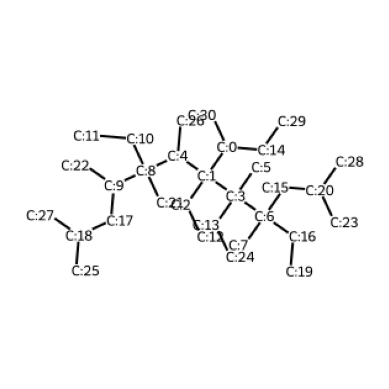

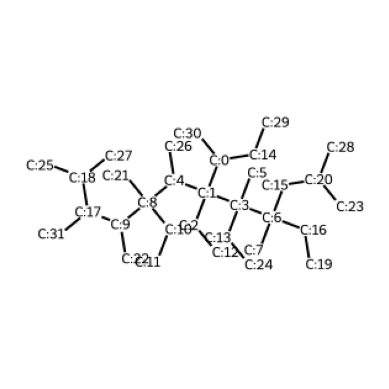

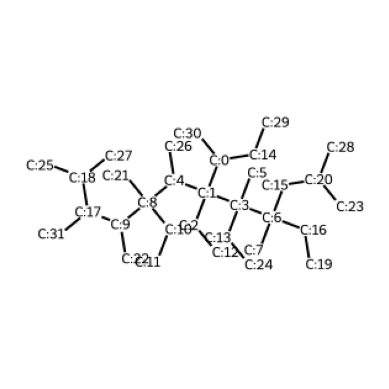

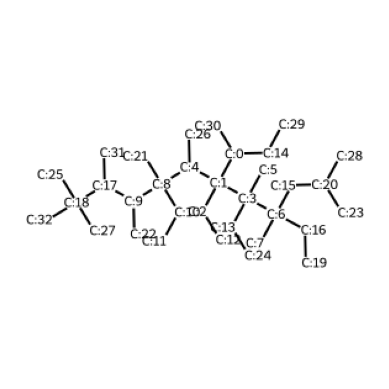

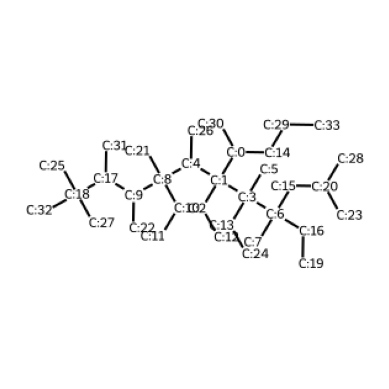

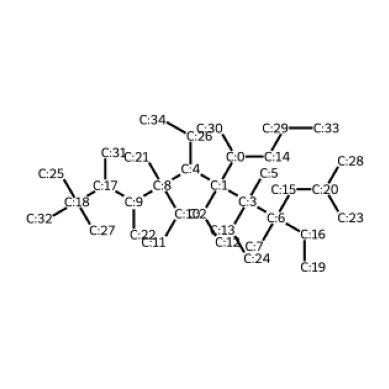

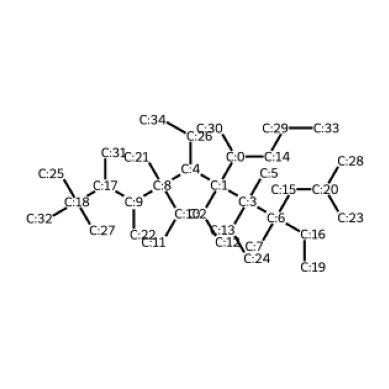

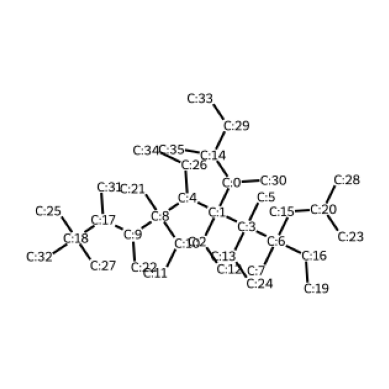

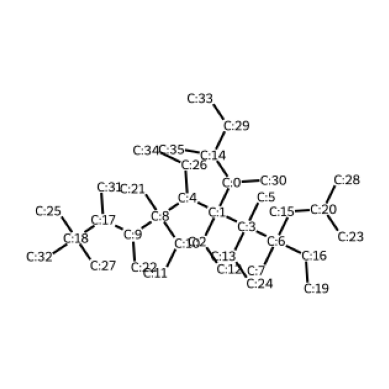

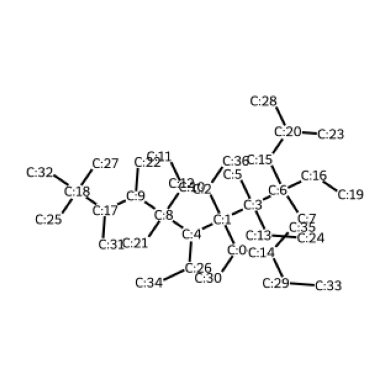

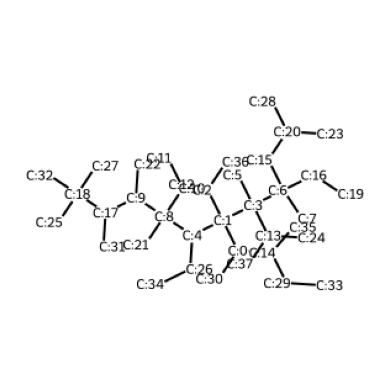

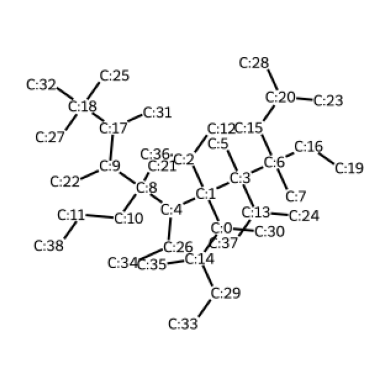

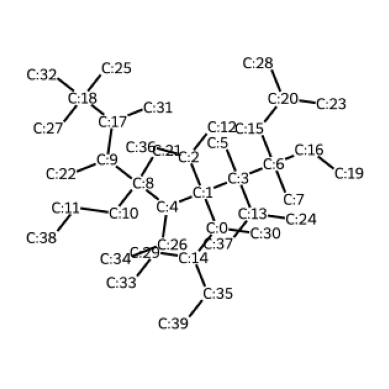

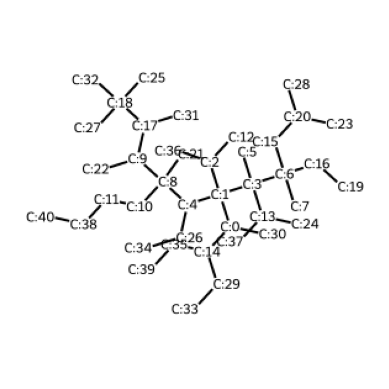

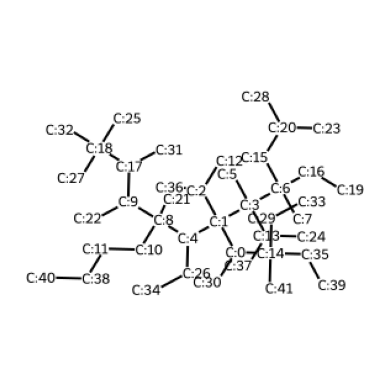

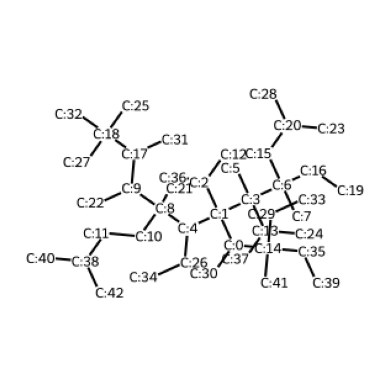

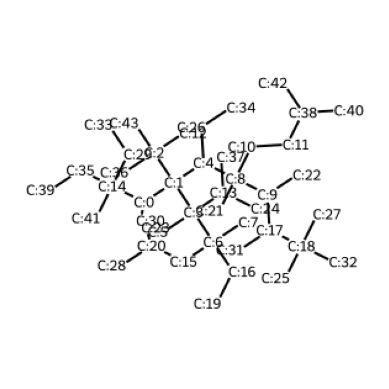

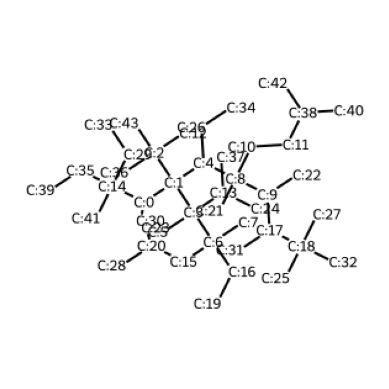

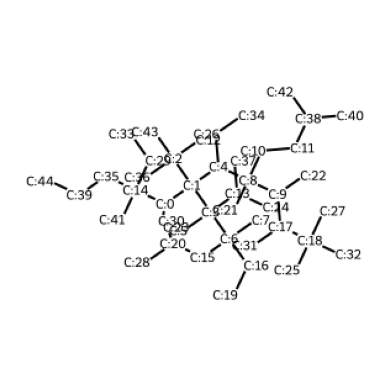

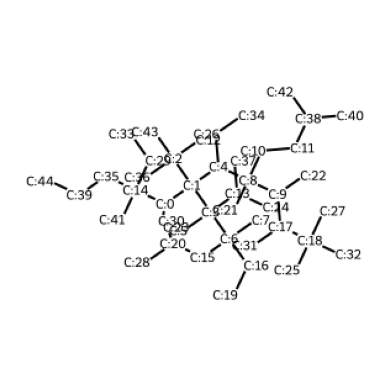

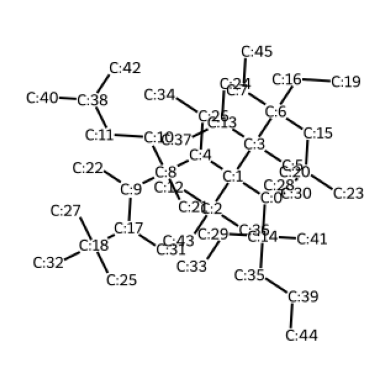

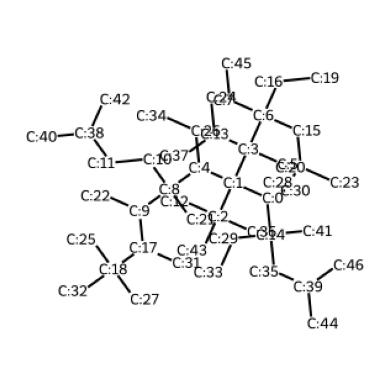

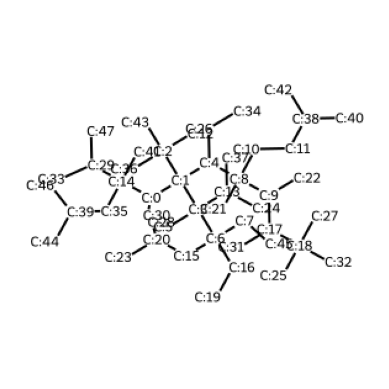

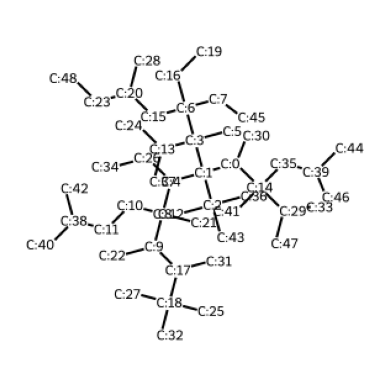

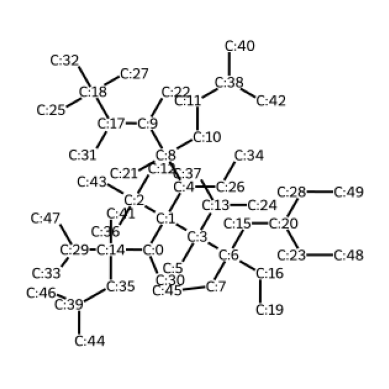

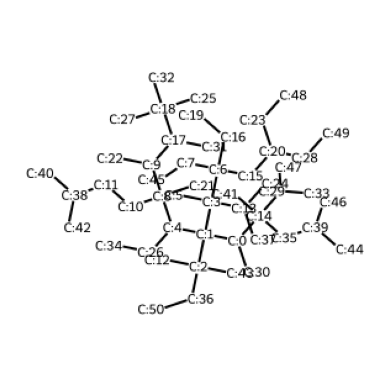

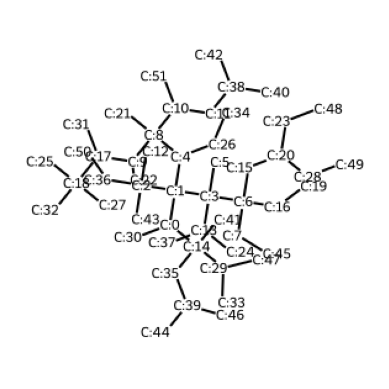

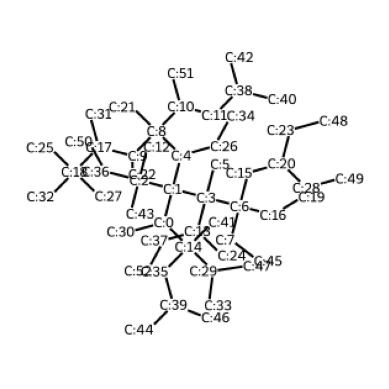

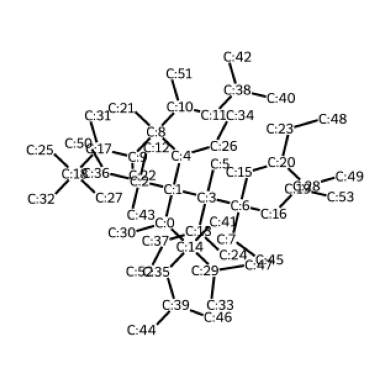

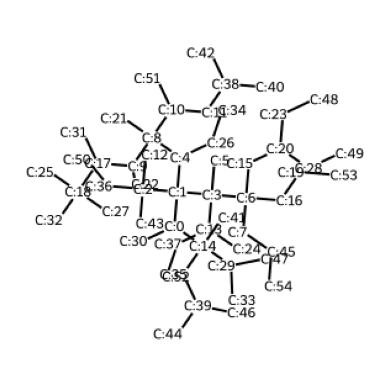

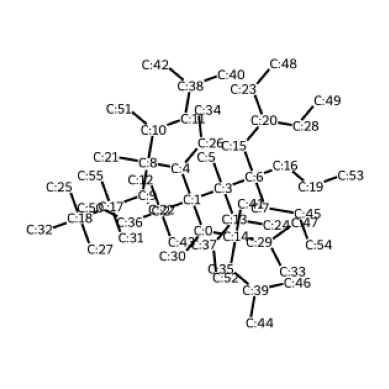

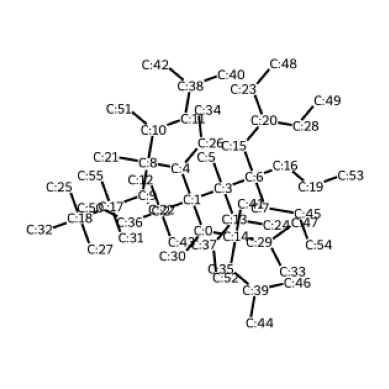

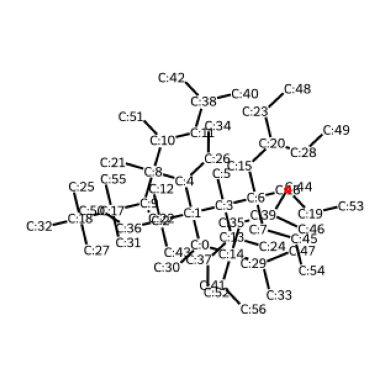

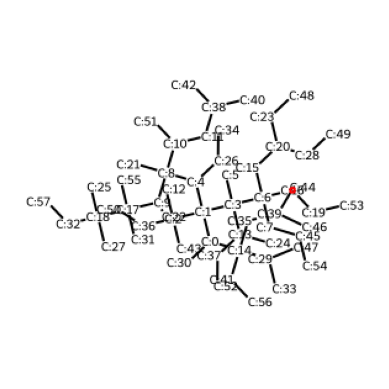

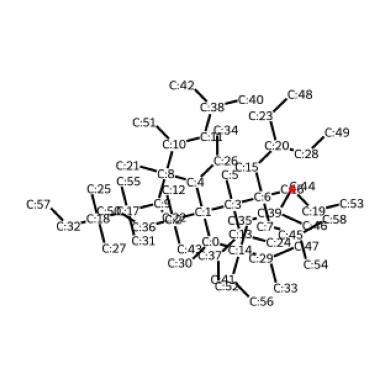

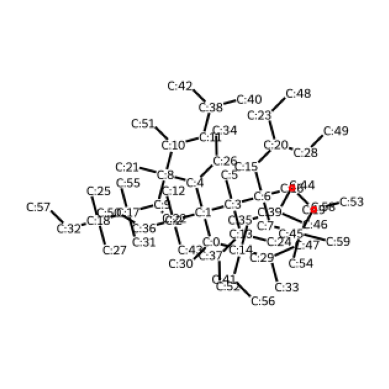

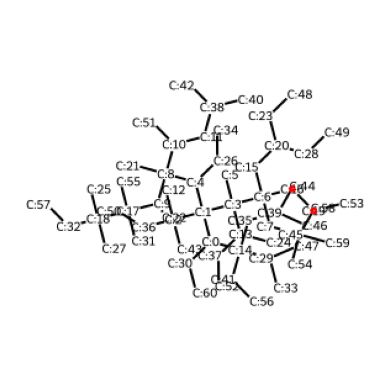

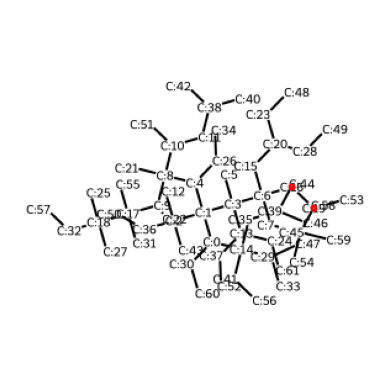

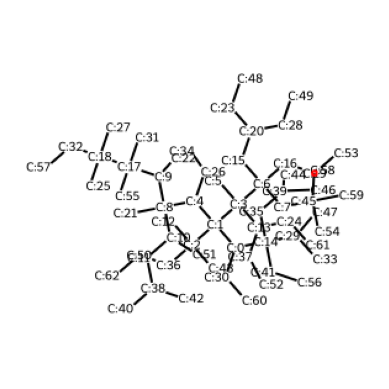

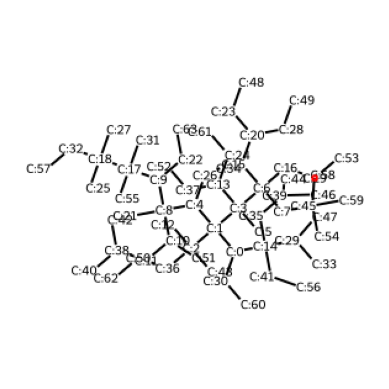

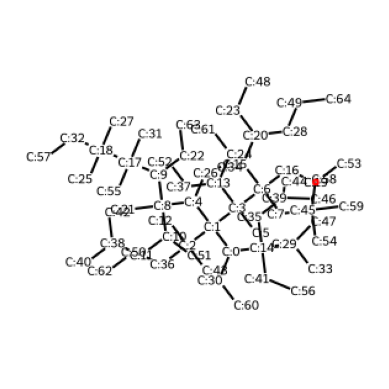

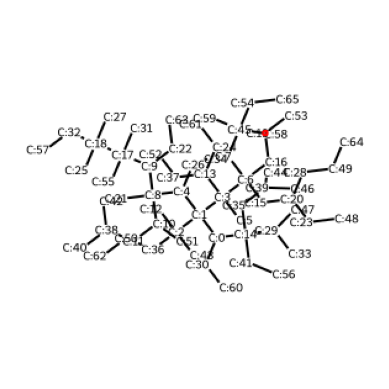

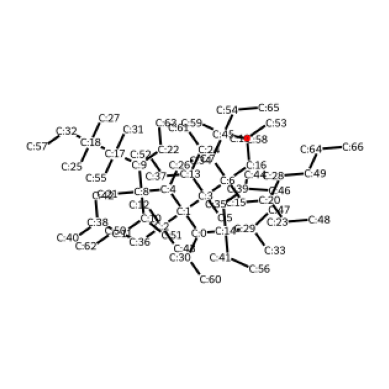

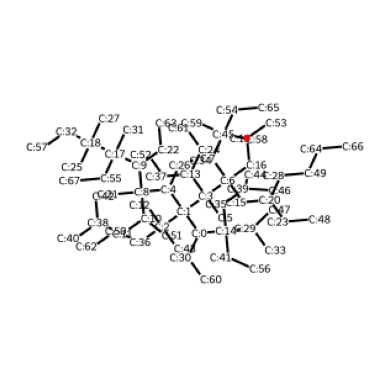

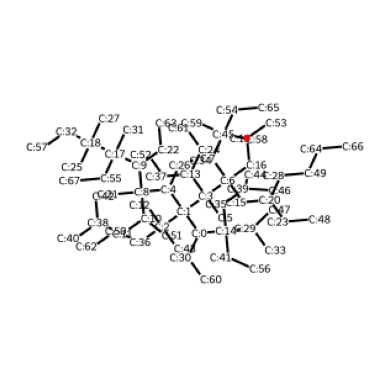

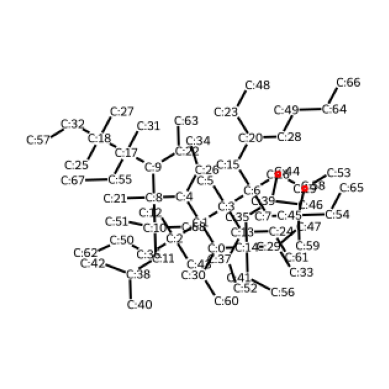

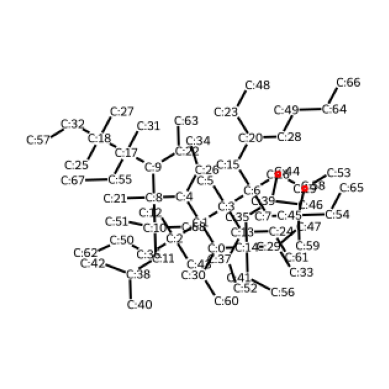

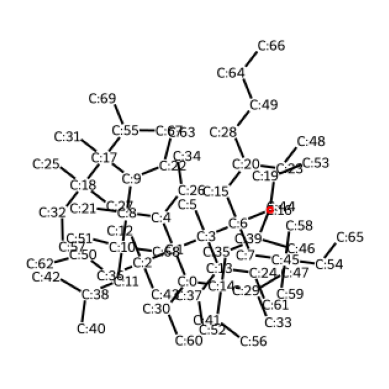

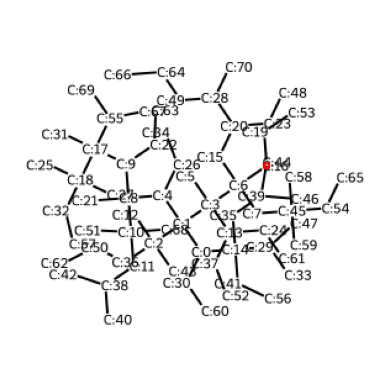

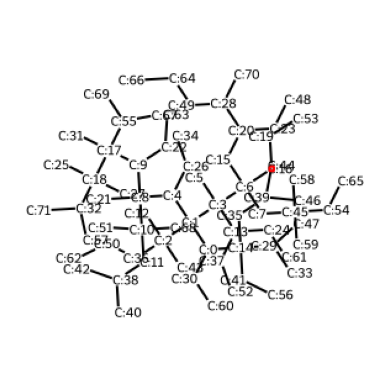

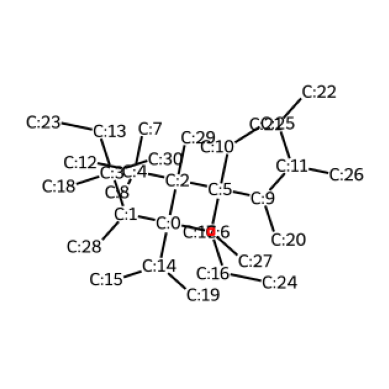

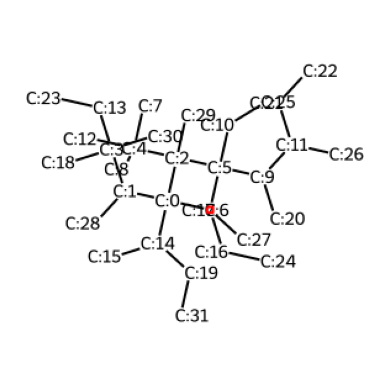

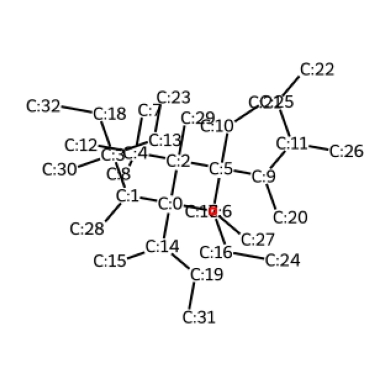

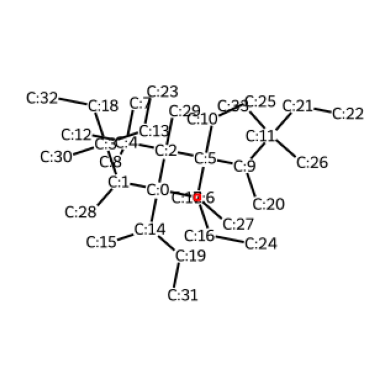

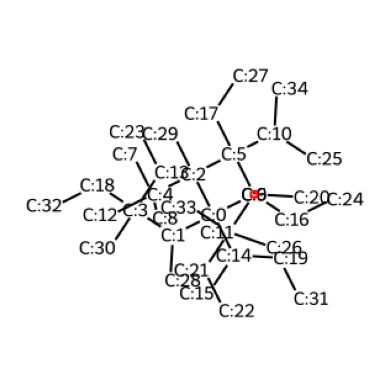

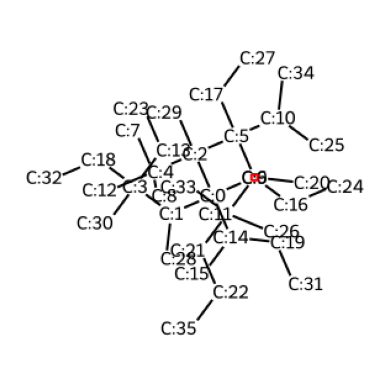

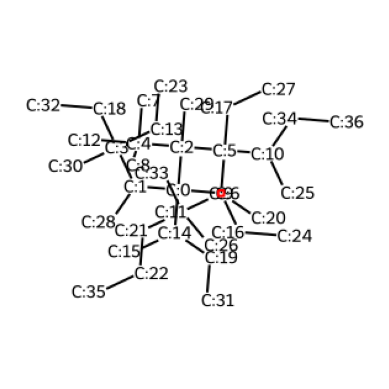

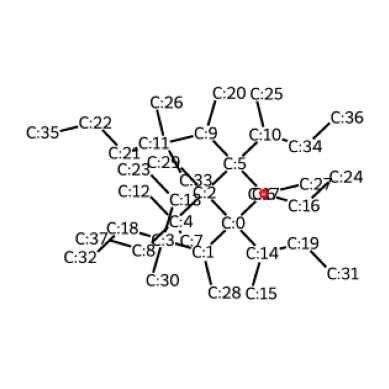

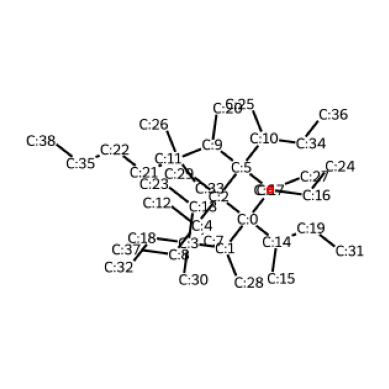

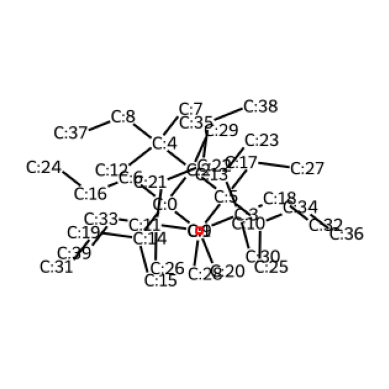

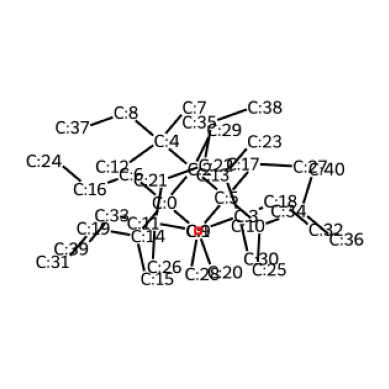

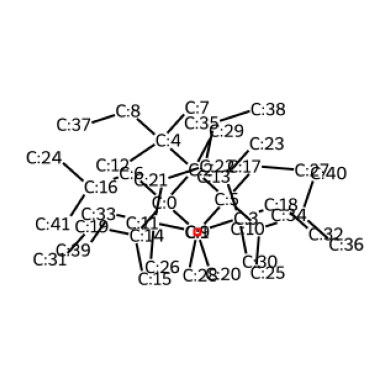

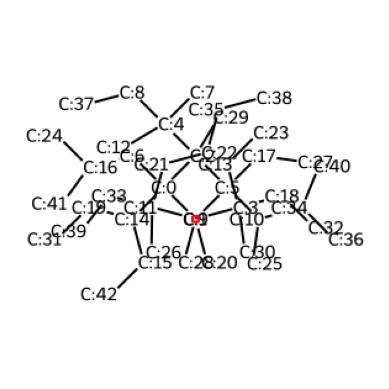

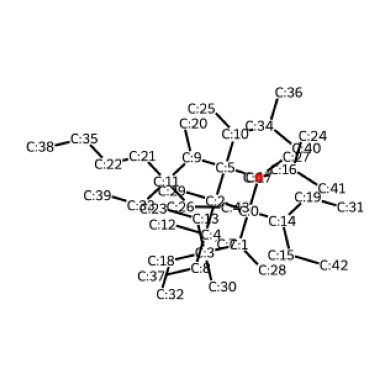

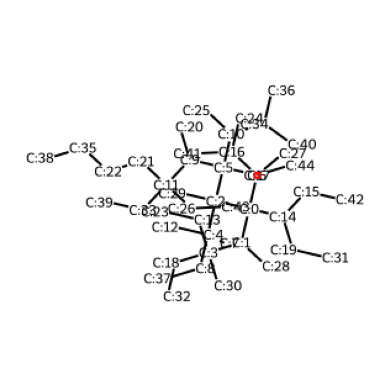

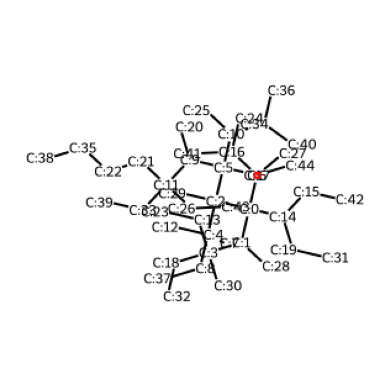

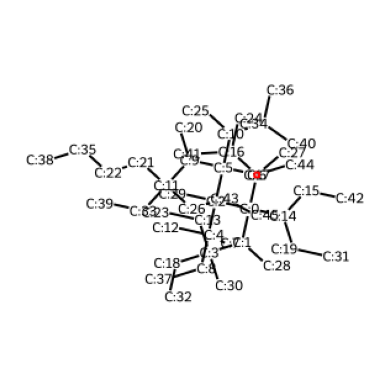

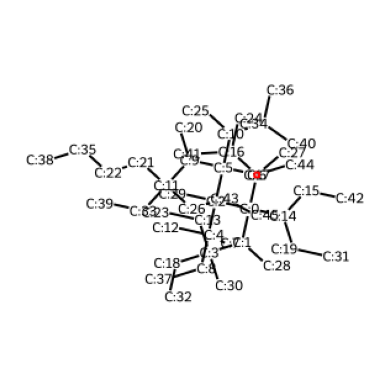

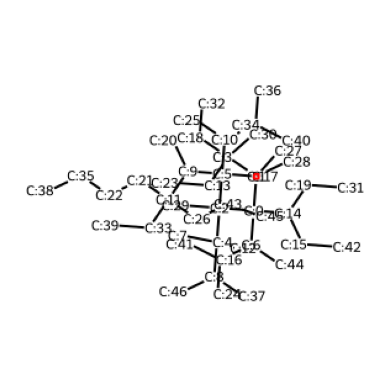

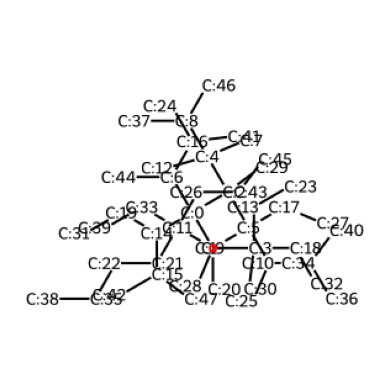

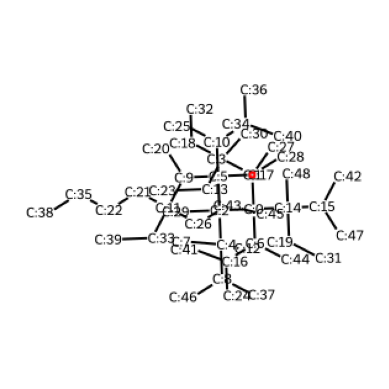

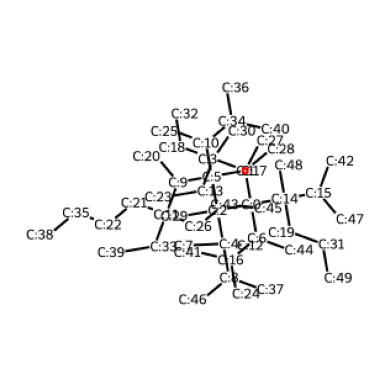

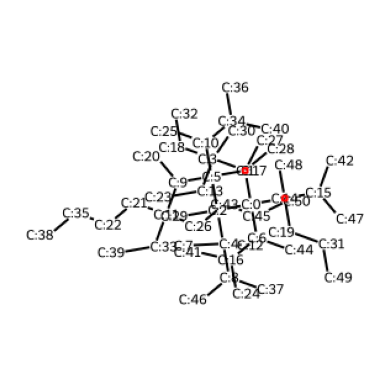

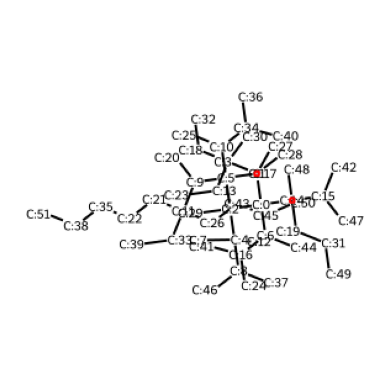

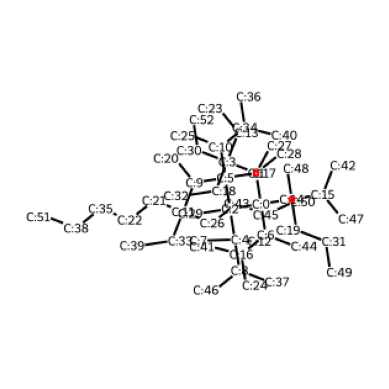

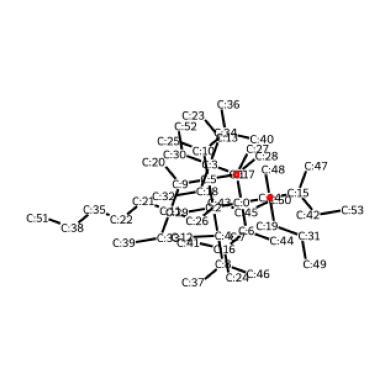

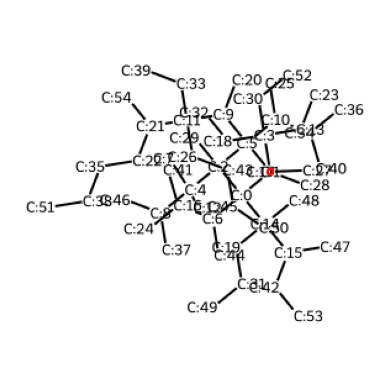

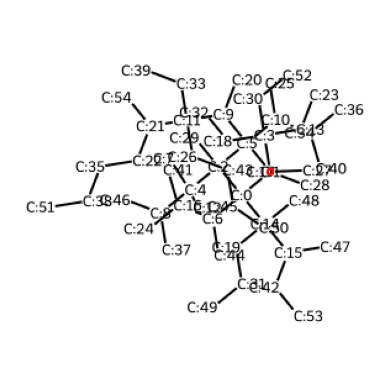

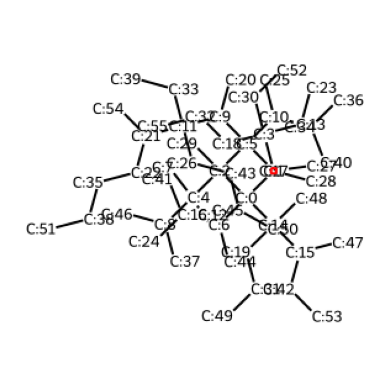

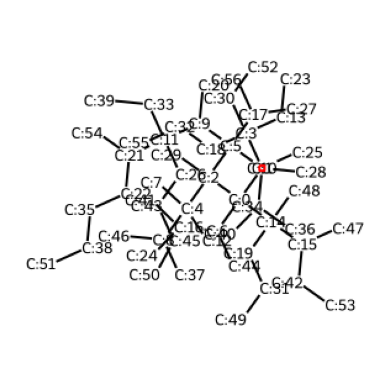

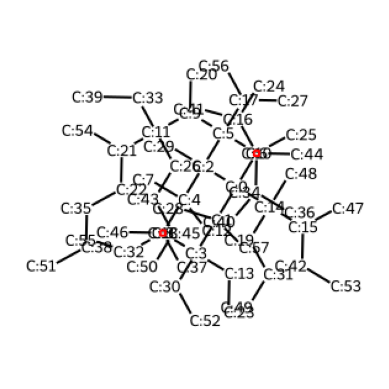

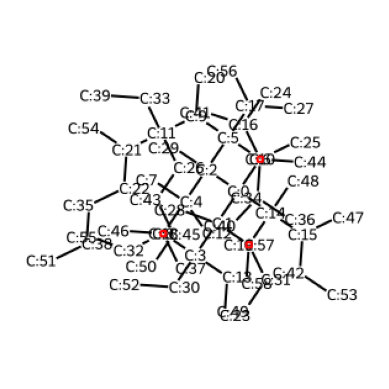

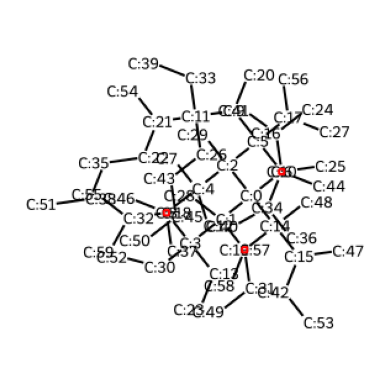

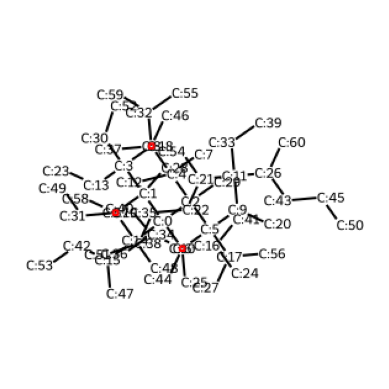

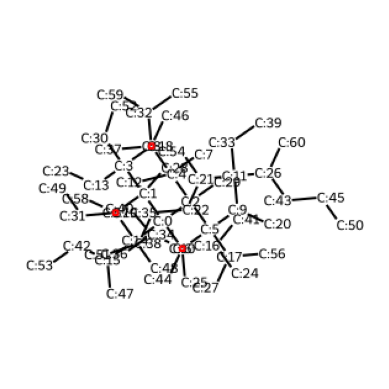

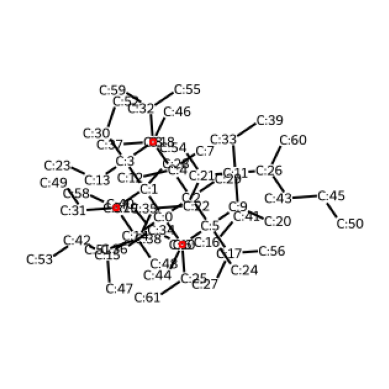

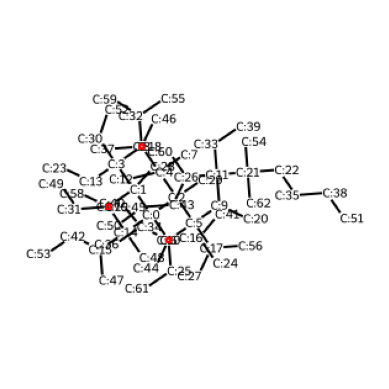

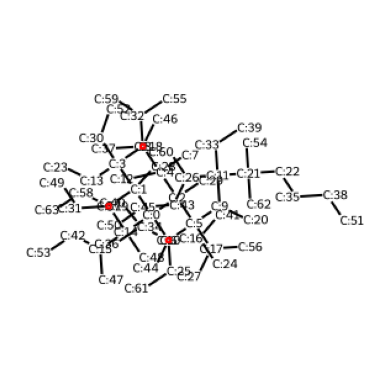

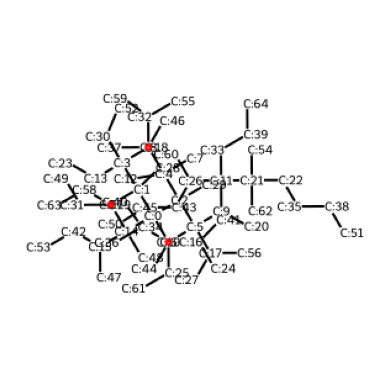

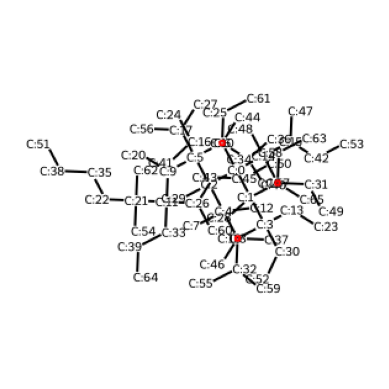

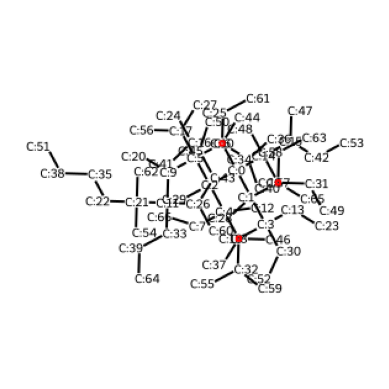

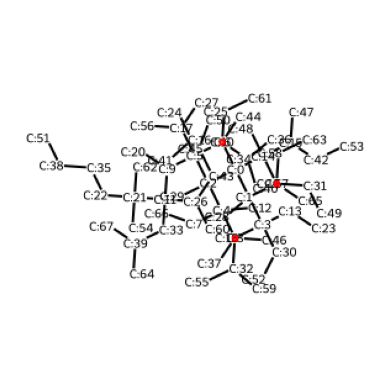

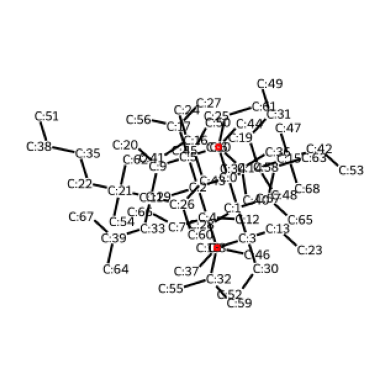

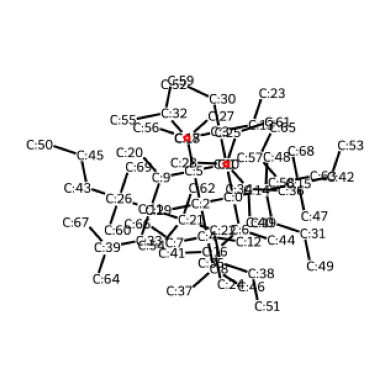

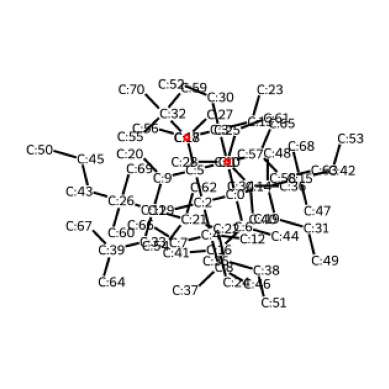

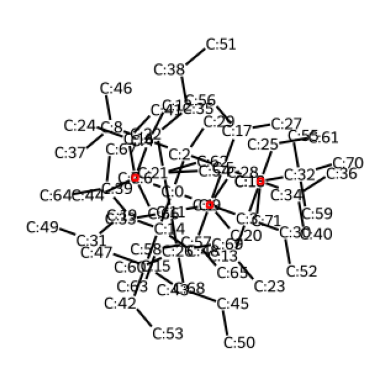

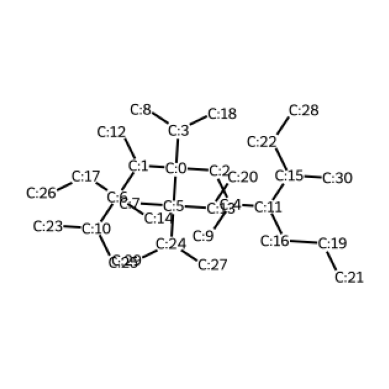

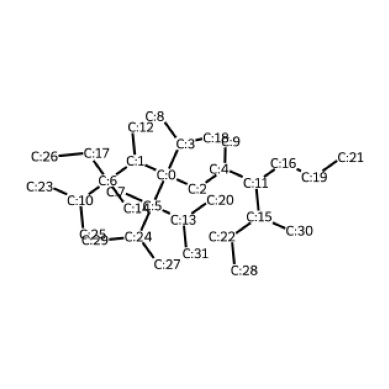

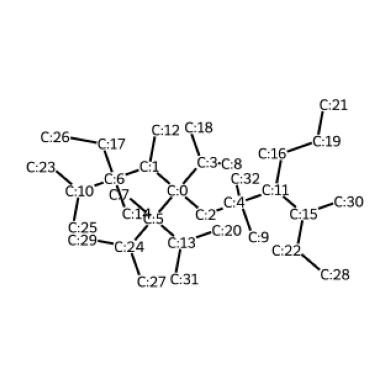

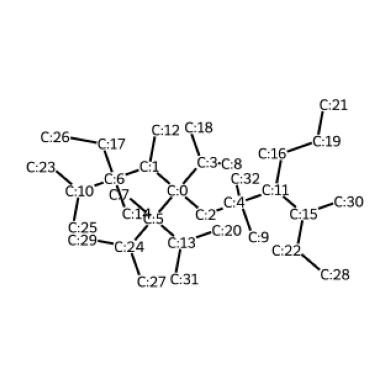

In [121]:
wandb.finish()

In [ ]:
env = vectorized_mol_env()
best_model.eval()
states = env.reset()
saved_s = []
for i in range(200):
    actions = best_model.act(states, batch_from_states(states))
    states, rewards, valids, timestep = env.step(actions['t'], actions['nmol'], actions['nfull'], actions['b'])
    if i == 0:
        saved_s = states
    else:
        saved_s = np.vstack((saved_s, states))
    if i % 200 == 0:
        states = env.reset()

if 1 in saved_actions['t']:
    flattened_states = []
    flattened_t = []
    for i in range(saved_states.shape[1]):
        states_col = saved_states[:, i].flatten().tolist()
        t_col = saved_actions['t'][:, i].flatten().tolist()
        if i == 0:
            flattened_states = states_col
            flattened_t = t_col
        else:
            flattened_states += states_col
            flattened_t += t_col
    
    idx = [i for i, t in enumerate(flattened_t) if t == 1]
    finished_states = [flattened_states[idx[i]] for i in range(len(idx))]
else:
    finished_states = [saved_states[i, saved_states.shape[1] - 1] for i in range(saved_states.shape[0])]


for i, state in enumerate(finished_states):
    if state.GetNumHeavyAtoms() > 30:
        print(i)
        Chem.SanitizeMol(state)
        visualize(state)

In [ ]:
Chem.MolToSmiles(finished_states[118].GetMol())